# General Publication Statistics about a Research Organization

This Notebook shows how it's possible to extract basic indicators about a research organization programmatically, using the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) and Jupyter Notebooks. 


## Load libraries and log in

In [1]:
# @markdown Click the 'play' button on the left (or shift+enter) after entering your API credentials

username = "" #@param {type: "string"}
password = "" #@param {type: "string"}
endpoint = "https://app.dimensions.ai" #@param {type: "string"}


!pip install dimcli plotly_express -U --quiet
import dimcli
from dimcli.shortcuts import *
dimcli.login(username, password, endpoint)
dsl = dimcli.Dsl()

#
# load common libraries
import time
import sys
import json
import pandas as pd
from tqdm import tqdm_notebook as tqdm

#
# charts libs
import plotly_express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

Dimcli - Dimensions API Client (v0.7)
Connected to: https://app.dimensions.ai - DSL v1.25
Method: dsl.ini file


## Choose a Research Organization

For the purpose of this exercise, we will are going to use [grid.168010.e](https://grid.ac/institutes/grid.168010.e) (Stanford University). Feel free though to change the parameters below as you want, eg by [choosing another GRID organization](https://grid.ac/institutes).


In [2]:
GRIDID = "grid.168010.e" #@param {type:"string"}

#
# gen link to Dimensions
#
def dimensions_url(grids):
    root = "https://app.dimensions.ai/discover/publication?or_facet_research_org="
    return root + "&or_facet_research_org=".join([x for x in grids])

from IPython.core.display import display, HTML
display(HTML('---<br /><a href="{}">Preview {} Dimensions &#x29c9;</a>'.format(dimensions_url([GRIDID]), GRIDID)))

## Publications output by year 

In [3]:
tot = dsl.query(f"""search publications where research_orgs.id="{GRIDID}" return publications limit 1""", verbose=False).count_total
print(f"{GRIDID} has a total of {tot} publications in Dimensions")

grid.168010.e has a total of 248554 publications in Dimensions


Returned Year: 100


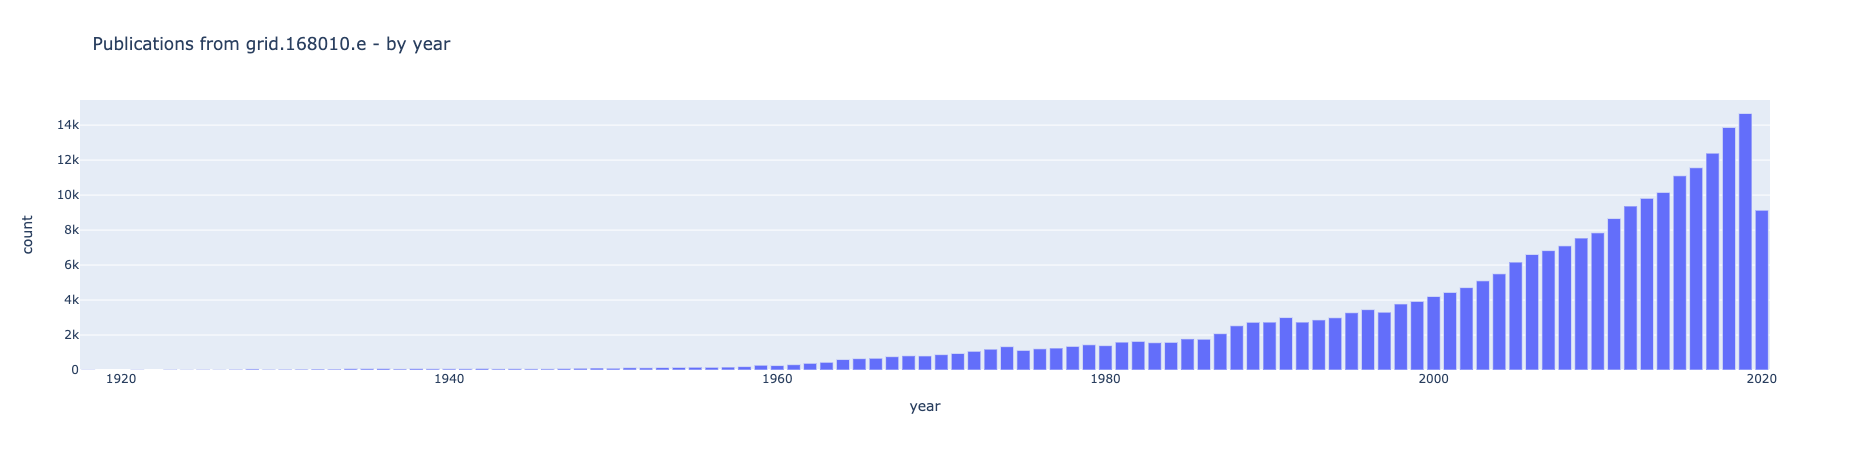

In [4]:
df = dsl.query(f"""search publications where research_orgs.id="{GRIDID}" return year limit 100""").as_dataframe() 
df.rename(columns={"id": "year"}, inplace=True)
#
px.bar(df, x="year", y="count", 
       title=f"Publications from {GRIDID} - by year")

## Publications most cited in last 2 years

In [5]:
data = dslquery(f"""search publications where research_orgs.id="{GRIDID}" 
        return publications[doi+title+recent_citations+category_for+journal] 
        sort by recent_citations limit 100""")
df = data.as_dataframe()
df.head(10)[['title', 'doi', 'recent_citations', 'journal.title']]

Returned Publications: 100 (total = 248554)


,title,doi,recent_citations,journal.title
0,ImageNet Large Scale Visual Recognition Challenge,10.1007/s11263-015-0816-y,6542,International Journal of Computer Vision
1,A global reference for human genetic variation,10.1038/nature15393,4096,Nature
2,"The Elements of Statistical Learning, Data Min...",10.1007/978-0-387-84858-7,4010,NaN
3,An integrated encyclopedia of DNA elements in ...,10.1038/nature11247,3866,Nature
4,Compressed Sensing,10.1109/tit.2006.871582,3799,IEEE Transactions on Information Theory
5,Planck 2015 results - XIII. Cosmological param...,10.1051/0004-6361/201525830,3500,Astronomy & Astrophysics
6,Building Theories from Case Study Research,10.5465/amr.1989.4308385,3284,Academy of Management Review
7,"Global, regional, and national prevalence of o...",10.1016/s0140-6736(14)60460-8,3114,The Lancet
8,Regularization and variable selection via the ...,10.1111/j.1467-9868.2005.00503.x,2922,Journal of the Royal Statistical Society Serie...
9,phyloseq: An R Package for Reproducible Intera...,10.1371/journal.pone.0061217,2694,PLoS ONE


## Publications most cited - all time

In [6]:
data = dslquery(f"""search publications 
                where research_orgs.id="{GRIDID}" 
                return publications[doi+title+times_cited+category_for+journal] 
                sort by times_cited limit 1000""")
df = data.as_dataframe()
df.head(10)[['title', 'doi', 'times_cited', 'journal.title']]

Returned Publications: 1000 (total = 248554)


,title,doi,times_cited,journal.title
0,Initial sequencing and analysis of the human g...,10.1038/35057062,15787,Nature
1,The american rheumatism association 1987 revis...,10.1002/art.1780310302,15595,Arthritis & Rheumatology
2,Compressed Sensing,10.1109/tit.2006.871582,15520,IEEE Transactions on Information Theory
3,Cluster analysis and display of genome-wide ex...,10.1073/pnas.95.25.14863,12235,Proceedings of the National Academy of Science...
4,The 1982 revised criteria for the classificati...,10.1002/art.1780251101,10856,Arthritis & Rheumatology
5,Building Theories from Case Study Research,10.5465/amr.1989.4308385,10593,Academy of Management Review
6,Atomic Force Microscope,10.1103/physrevlett.56.930,10354,Physical Review Letters
7,An integrated encyclopedia of DNA elements in ...,10.1038/nature11247,9736,Nature
8,Molecular portraits of human breast tumours,10.1038/35021093,9722,Nature
9,Significance analysis of microarrays applied t...,10.1073/pnas.091062498,9254,Proceedings of the National Academy of Science...


## Publications most cited : which research areas?

In [7]:
data = dslquery(f"""search publications 
                    where research_orgs.id="{GRIDID}" 
                    return publications[doi+title+times_cited+category_for+journal] 
                    sort by times_cited limit 1000""")

Returned Publications: 1000 (total = 248554)


Most publications have one or more associated Field Of Research (FOR) category, which is represented in the JSON like this:

```
{'category_for' : [{'id': '3292', 'name': '1402 Applied Economics'}, 
                    {'id': '3177', 'name': '1117 Public Health and Health Services'}]
                    }`
```

However since some publications may not have an associated FOR category, the resulting JSON in some cases may not have `category_for` as a key. Since we want to import the data into pandas we need to ensure the key is always there and has an empty list when no category is available.  

In [8]:
# dimcli.shortcuts.normalize_key takes: field name / json list / value to add when the field is not found
normalize_key("category_for", data.publications, [])

In [9]:
df = pd.json_normalize(data.publications, record_path='category_for', meta=['doi', 'title', 'times_cited', ], errors='ignore' )
df.head()

,id,name,doi,title,times_cited
0,2620,0604 Genetics,10.1038/35057062,Initial sequencing and analysis of the human g...,15787
1,2206,06 Biological Sciences,10.1038/35057062,Initial sequencing and analysis of the human g...,15787
2,2211,11 Medical and Health Sciences,10.1002/art.1780310302,The american rheumatism association 1987 revis...,15595
3,3053,1103 Clinical Sciences,10.1002/art.1780310302,The american rheumatism association 1987 revis...,15595
4,2208,08 Information and Computing Sciences,10.1109/tit.2006.871582,Compressed Sensing,15520


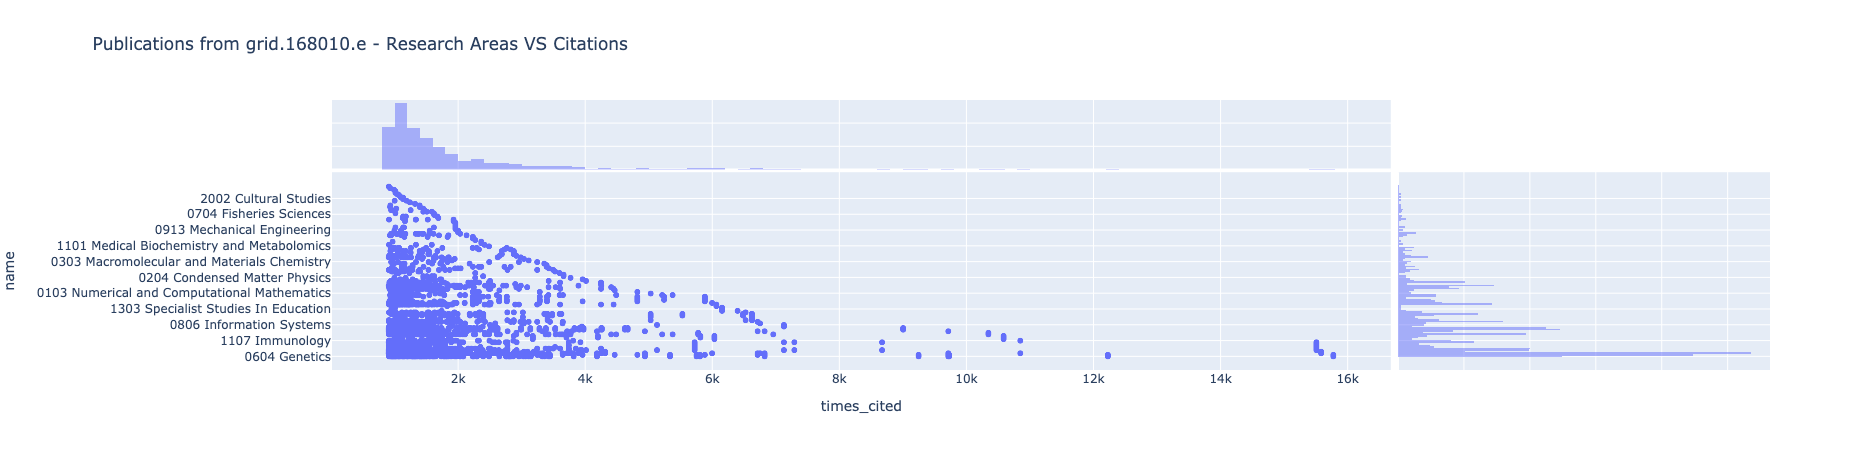

In [10]:
px.scatter(df, x="times_cited", y="name", 
           marginal_x="histogram", marginal_y="histogram", 
           hover_data=["doi", "title"],
           title=f"Publications from {GRIDID} - Research Areas VS Citations")

## Publications most cited : which journals?

Returned Publications: 1000 (total = 248554)


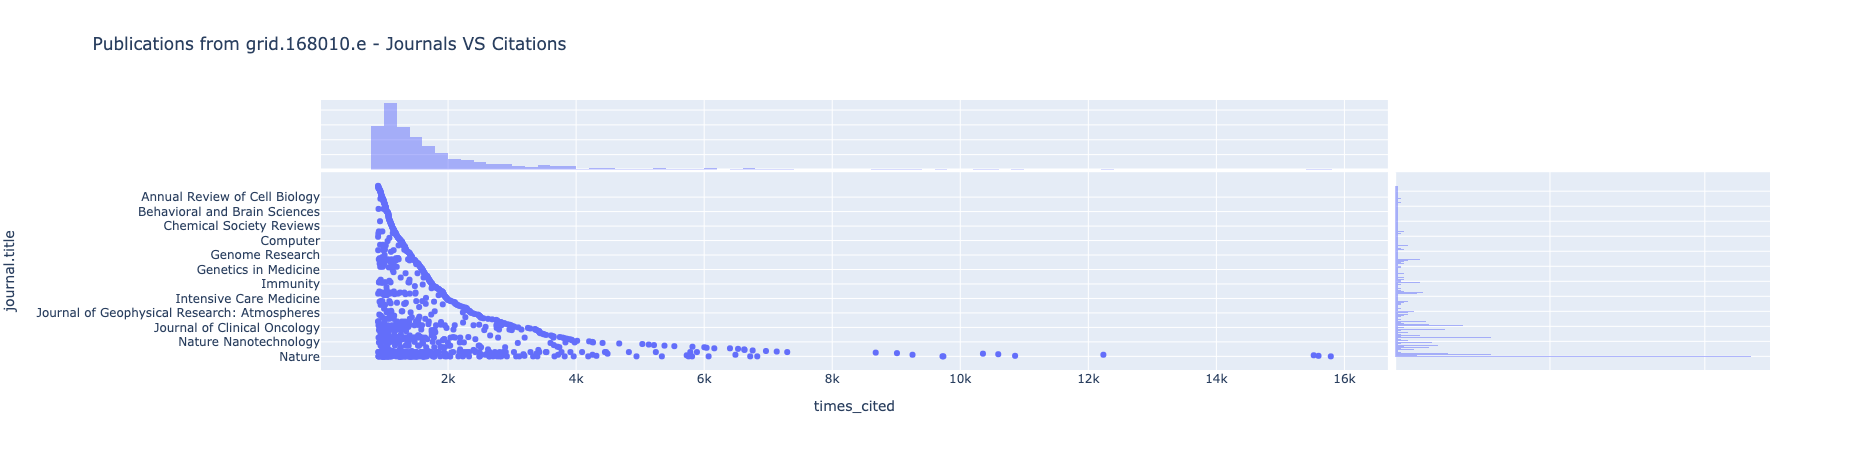

In [11]:
data = dslquery(f"""search publications 
                    where research_orgs.id="{GRIDID}" 
                    return publications[doi+title+times_cited+category_for+journal] 
                    sort by times_cited limit 1000""")

df = data.as_dataframe()
#
px.scatter(df, x="times_cited", y="journal.title", 
           marginal_x="histogram", marginal_y="histogram", 
           title=f"Publications from {GRIDID} - Journals VS Citations")

## Top Funders (by aggregated funding amount)

In [12]:
fundersdata = dsl.query(f"""search grants 
                        where research_orgs.id="{GRIDID}" 
                        return funders aggregate funding 
                        sort by funding""")
df = fundersdata.as_dataframe()
df.head(10)

Returned Funders: 20


,id,count,funding,city_name,latitude,linkout,name,state_name,acronym,country_name,longitude,types
0,grid.48336.3a,773,1.030931e+09,Rockville,39.004326,[http://www.cancer.gov/],National Cancer Institute,Maryland,NCI,United States,-77.101190,[Government]
1,grid.280785.0,760,1.009057e+09,Bethesda,38.997833,[http://www.nigms.nih.gov/Pages/default.aspx],National Institute of General Medical Sciences,Maryland,NIGMS,United States,-77.099380,[Facility]
2,grid.419681.3,564,7.325643e+08,Bethesda,39.066647,[http://www.niaid.nih.gov/Pages/default.aspx],National Institute of Allergy and Infectious D...,Maryland,NIAID,United States,-77.111830,[Facility]
3,grid.279885.9,599,7.231477e+08,Bethesda,39.004280,[http://www.nhlbi.nih.gov/],National Heart Lung and Blood Institute,Maryland,NHLBI,United States,-77.100945,[Facility]
4,grid.457875.c,1282,6.677870e+08,Arlington,38.880566,[http://www.nsf.gov/dir/index.jsp?org=MPS],Directorate for Mathematical & Physical Sciences,Virginia,NSF MPS,United States,-77.110990,[Government]
5,grid.280128.1,139,5.928483e+08,Bethesda,38.996967,[https://www.genome.gov/],National Human Genome Research Institute,Maryland,NHGRI,United States,-77.096930,[Facility]
6,grid.416870.c,515,5.867405e+08,Bethesda,39.003826,[http://www.ninds.nih.gov/],National Institute of Neurological Disorders a...,Maryland,NINDS,United States,-77.101180,[Facility]
7,grid.416868.5,508,5.306851e+08,Bethesda,39.003693,[https://www.nimh.nih.gov/index.shtml],National Institute of Mental Health,Maryland,NIMH,United States,-77.104570,[Facility]
8,grid.418557.a,138,4.900643e+08,San Francisco,37.778034,[https://www.cirm.ca.gov/],California Institute for Regenerative Medicine,California,CIRM,United States,-122.392340,[Government]
9,grid.457799.1,129,4.035651e+08,Arlington,38.880580,[http://www.nsf.gov/dir/index.jsp?org=EHR],Directorate for Education & Human Resources,Virginia,NSF EHR,United States,-77.111000,[Government]


## Top funders split by country of the funder

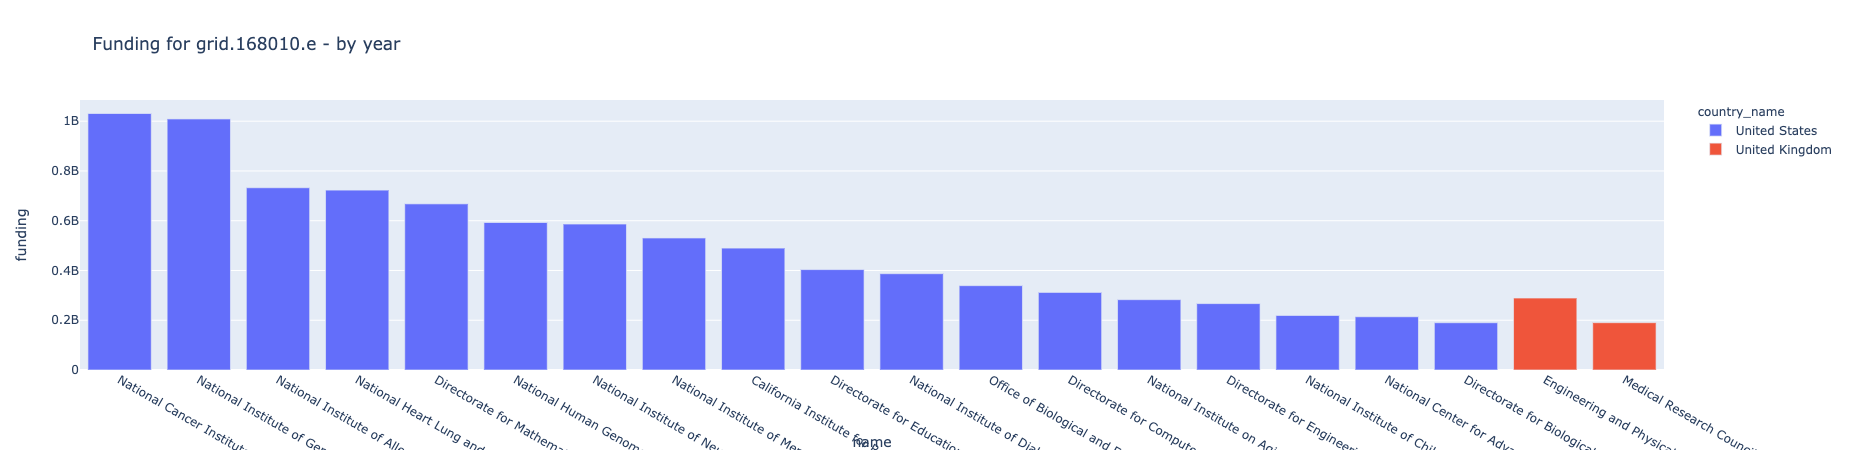

In [13]:
px.bar(df, x="name", y="funding", color="country_name",
       title=f"Funding for {GRIDID} - by year")

## Correlation between No of Publications VS Funding

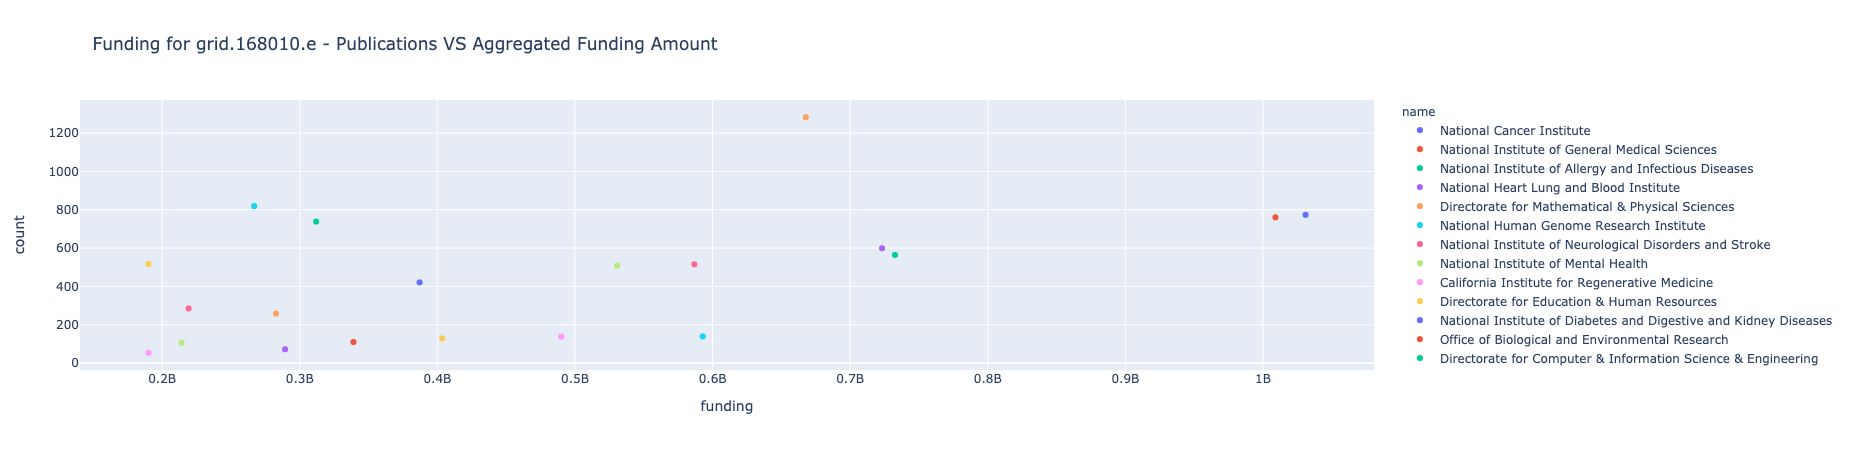

In [14]:
px.scatter(df, x="funding", y="count", color="name", 
           title=f"Funding for {GRIDID} - Publications VS Aggregated Funding Amount")